In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer


In [4]:

torch.cuda.is_available()


True

In [5]:

# ====== 1. Load Dataset ======
dataset = load_dataset("SEACrowd/liputan6", trust_remote_code=True)
train_data = dataset['train'].shuffle(seed=42).select(range(500))
val_data = dataset['validation'].shuffle(seed=42).select(range(100))
test_data = dataset['test'].shuffle(seed=42).select(range(100))
print(train_data, val_data, test_data)
# ====== 2. Initialize Tokenizer ======
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


Dataset({
    features: ['document', 'id', 'summary'],
    num_rows: 500
}) Dataset({
    features: ['document', 'id', 'summary'],
    num_rows: 100
}) Dataset({
    features: ['document', 'id', 'summary'],
    num_rows: 100
})


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:

# Tokenization and Preprocessing Function
def preprocess_function(examples):
    inputs = examples['document']
    targets = examples['summary']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs['labels'] = labels['input_ids']
    return model_inputs



In [7]:
# Apply preprocessing
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_val = val_data.map(preprocess_function, batched=True)

# Convert to PyTorch DataLoader
class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset):
        self.dataset = tokenized_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.dataset[idx]['input_ids'], dtype=torch.long),
            'labels': torch.tensor(self.dataset[idx]['labels'], dtype=torch.long)
        }

train_dataset = SummarizationDataset(tokenized_train)
val_dataset = SummarizationDataset(tokenized_val)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=8)


In [8]:
# Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)


In [ ]:
# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linear_Q = nn.Linear(d_model, d_model)
        self.linear_K = nn.Linear(d_model, d_model)
        self.linear_V = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.attention = ScaledDotProductAttention()

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        Q = self.linear_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        attn_output = self.attention(Q, K, V, mask)
        concat = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linear_out(concat)
    


In [10]:
# Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))
    


In [11]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        return self.norm2(x + ff_output)
    


In [12]:
# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attention = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        self_attn_output = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self_attn_output)
        enc_dec_attn_output = self.enc_dec_attention(x, enc_output, enc_output, memory_mask)
        x = self.norm2(x + enc_dec_attn_output)
        ff_output = self.ff(x)
        return self.norm3(x + ff_output) 


In [ ]:
# Transformer Model
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        seq_len_src = src.size(1)
        seq_len_tgt = tgt.size(1)
        src = self.encoder_embedding(src) + self.positional_encoding[:, :seq_len_src, :]
        tgt = self.decoder_embedding(tgt) + self.positional_encoding[:, :seq_len_tgt, :]

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, tgt_mask)

        return self.output_layer(tgt) 
    


In [21]:
# Model Hyperparameters
vocab_size = tokenizer.vocab_size
d_model = 512
num_heads = 16
d_ff = 2048
num_layers = 6
max_seq_len = 512
learning_rate = 5e-5
num_epochs = 10


In [22]:

# Model Initialization
model = Transformer(vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [23]:
import matplotlib.pyplot as plt

# Function to calculate accuracy
def calculate_accuracy(predictions, targets):
    # Remove padding tokens (which are ignored in the loss calculation)
    predictions = predictions.reshape(-1)  # Use reshape instead of view
    targets = targets.reshape(-1)  # Use reshape instead of view
    mask = targets != tokenizer.pad_token_id
    correct = (predictions == targets) & mask
    accuracy = correct.sum().item() / mask.sum().item()
    return accuracy

# List to store accuracy values
train_accuracies = []
val_accuracies = []
# List to store loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    for batch in tqdm(train_dataloader):
        src = batch['input_ids'].to(device)
        tgt = batch['labels'].to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        outputs = model(src, tgt_input)
        loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.argmax(dim=-1)
        accuracy = calculate_accuracy(predictions, tgt_output)
        total_train_accuracy += accuracy

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            src = batch['input_ids'].to(device)
            tgt = batch['labels'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            outputs = model(src, tgt_input)
            loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
            total_val_loss += loss.item()

            # Calculate accuracy
            predictions = outputs.argmax(dim=-1)
            accuracy = calculate_accuracy(predictions, tgt_output)
            total_val_accuracy += accuracy

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_accuracy = total_val_accuracy / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    # Print loss and accuracy for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")




100%|██████████| 63/63 [03:52<00:00,  3.69s/it]


Epoch 1/10, Train Loss: 5.2261, Train Accuracy: 0.0177, Val Loss: 3.7762, Val Accuracy: 0.0516


100%|██████████| 63/63 [03:47<00:00,  3.61s/it]


Epoch 2/10, Train Loss: 4.0622, Train Accuracy: 0.0591, Val Loss: 3.1937, Val Accuracy: 0.0782


100%|██████████| 63/63 [03:09<00:00,  3.00s/it]


Epoch 3/10, Train Loss: 3.5603, Train Accuracy: 0.0959, Val Loss: 2.8803, Val Accuracy: 0.1355


100%|██████████| 63/63 [03:04<00:00,  2.92s/it]


Epoch 4/10, Train Loss: 3.2500, Train Accuracy: 0.1458, Val Loss: 2.6800, Val Accuracy: 0.1786


100%|██████████| 63/63 [03:00<00:00,  2.86s/it]


Epoch 5/10, Train Loss: 3.0380, Train Accuracy: 0.1841, Val Loss: 2.5468, Val Accuracy: 0.2061


100%|██████████| 63/63 [03:08<00:00,  2.99s/it]


Epoch 6/10, Train Loss: 2.8766, Train Accuracy: 0.2117, Val Loss: 2.4540, Val Accuracy: 0.2260


100%|██████████| 63/63 [02:58<00:00,  2.83s/it]


Epoch 7/10, Train Loss: 2.7476, Train Accuracy: 0.2312, Val Loss: 2.3759, Val Accuracy: 0.2390


100%|██████████| 63/63 [03:08<00:00,  2.99s/it]


Epoch 8/10, Train Loss: 2.6355, Train Accuracy: 0.2464, Val Loss: 2.3200, Val Accuracy: 0.2438


100%|██████████| 63/63 [03:04<00:00,  2.92s/it]


Epoch 9/10, Train Loss: 2.5419, Train Accuracy: 0.2562, Val Loss: 2.2741, Val Accuracy: 0.2582


100%|██████████| 63/63 [03:02<00:00,  2.90s/it]


Epoch 10/10, Train Loss: 2.4536, Train Accuracy: 0.2662, Val Loss: 2.2373, Val Accuracy: 0.2572


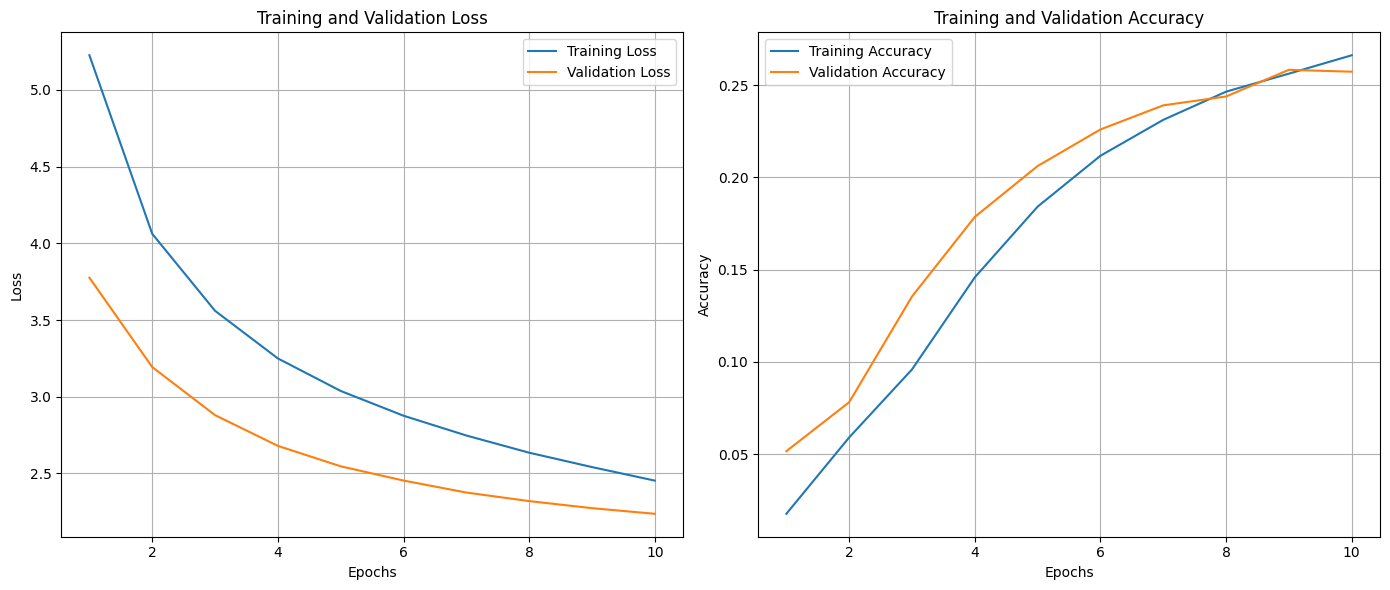

In [25]:
# Plot training and validation loss
plt.figure(figsize=(14, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [30]:
print(type(val_data))
print(val_data[:2])  # Tampilkan 2 elemen pertama


<class 'datasets.arrow_dataset.Dataset'>
{'document': ['Liputan6 . com , Jakarta : Mantan Menteri Pertambangan dan Energi Ginandjar Kartasasmita mengaku telah menerima panggilan Kejaksaan Agung . Tapi , dia keberatan diperiksa sebagai tersangka dalam Kasus Technical Assistance Contract ( TAC ) antara Pertamina dan PT Ustraindo Petro Gas . Dia menuding status yang dikeluarkan Kejagung lebih bermuatan politis dibanding pertimbangan hukum . Pernyataan itu diungkapkan Ginandjar dalam jumpa pers yang digelar di kediamannya di Jalan Widya Chandra V Nomor 26 , Jakarta Selatan , Selasa ( 20/3 ) . Petinggi Partai Golongan Karya itu mengaku tak pernah ingkar janji soal pemanggilan Kejagung . Tapi , dia keberatan dengan status tersangka dalam kasus korupsi yang merugikan negara sebesar US$ 17 , 4 juta itu . Sebab , dia hanya melaksanakan kebijakan pemerintah selama proses persiapan dan perundingan . Dia menolak dituding berperan aktif dalam TAC tersebut . Ginandjar menambahkan , penunjukan PT Ust

In [37]:
def greedy_decode(model, input_ids, max_length=150):
    # Mengatur model dalam mode evaluasi (tidak ada dropout)
    model.eval()

    # Mengirimkan input ke device
    input_ids = input_ids.to(device)
    
    # Membuat tensor kosong untuk menyimpan output
    generated_ids = input_ids

    for _ in range(max_length):
        # Forward pass untuk mendapatkan output dari model
        outputs = model(generated_ids)  # Menggunakan decoder bagian model
        logits = outputs[:, -1, :]  # Ambil output terakhir

        # Pilih token dengan probabilitas tertinggi (greedy)
        predicted_id = logits.argmax(dim=-1).unsqueeze(-1)

        # Gabungkan dengan sequence yang sudah ada
        generated_ids = torch.cat((generated_ids, predicted_id), dim=-1)

        # Jika token EOS (end of sequence) muncul, berhenti
        if predicted_id.item() == tokenizer.eos_token_id:
            break

    return generated_ids


In [38]:
def decode_output(generated_ids, tokenizer):
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text


In [50]:
# Fungsi untuk menghitung BLEU score dan menghasilkan ringkasan
def calculate_bleu_and_generate_summary(model, tokenizer, dataset, num_samples=50):
    smoothing = SmoothingFunction().method1
    results = []
    total_bleu_score = 0  # Variabel untuk menjumlahkan semua BLEU score
    
    # Looping sesuai jumlah sampel yang diminta
    for i in range(num_samples):
        source_text = dataset[i]['document']  # Mengakses teks sumber
        reference_summary = dataset[i]['summary']  # Mengakses ringkasan referensi
        
        # Tokenisasi teks sumber dan ringkasan referensi
        inputs = tokenizer(source_text, return_tensors="pt", max_length=512, truncation=True)
        target_inputs = tokenizer(reference_summary, return_tensors="pt", max_length=128, truncation=True)
        
        # Dapatkan output dari model (menggunakan forward)
        src = inputs['input_ids'].to(device)
        tgt = target_inputs['input_ids'].to(device)
        
        # Mendapatkan output model
        outputs = model(src, tgt)
        
        # Ambil hasil output dan lakukan decoding (misalnya ambil logit dan cari indeks tertinggi)
        predicted_ids = torch.argmax(outputs, dim=-1)  # Menyaring hasil prediksi
        predicted_summary = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
        
        # Hitung BLEU score
        reference_tokens = [reference_summary.split()]
        predicted_tokens = predicted_summary.split()
        bleu_score = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smoothing)
        total_bleu_score += bleu_score  # Tambahkan BLEU score ke total
        
        # Simpan hasil dalam dictionary
        results.append({
            'source_text': source_text,
            'reference_summary': reference_summary,
            'predicted_summary': predicted_summary,
            'bleu_score': bleu_score
        })
    
    # Hitung rata-rata BLEU score
    average_bleu_score = total_bleu_score / num_samples
    return results, average_bleu_score

# Contoh penggunaan
num_samples_to_test = 50  # Ganti dengan jumlah sampel yang ingin diuji
results, avg_bleu_score = calculate_bleu_and_generate_summary(model, tokenizer, test_data, num_samples=num_samples_to_test)

# Cetak hasil BLEU score dan prediksi untuk 2 contoh
print("Contoh Hasil Prediksi:\n")
for i, result in enumerate(results[:2]):  # Ambil 2 contoh pertama
    print(f"Contoh {i+1}:")
    print(f"Original Text:\n{result['source_text']}\n")
    print(f"Reference Summary:\n{result['reference_summary']}\n")
    print(f"Predicted Summary:\n{result['predicted_summary']}\n")
    print(f"BLEU Score: {result['bleu_score']}\n")
    print("-" * 80)

# Cetak rata-rata BLEU score
print(f"Average BLEU Score: {avg_bleu_score}")



Contoh Hasil Prediksi:

Contoh 1:
Original Text:
Liputan6 . com , Jakarta : Tersiar kabar , Presiden Megawati telah menunjuk Komisaris Jenderal Polisi Da i Bachtiar sebagai pelaksana harian atau pejabat sementara kepala Polri . Selain itu , beredar kabar pula bahwa jabatan Laksamana TNI Widodo A . S . sebagai panglima TNI akan digeser . Tapi , baru-baru ini , Sekretaris Negara/Kabinet Bambang Kesowo membantah kabar itu . Bahkan , Bambang tak yakin jika presiden telah mengeluarkan dua keputusan itu . " Saya tak yakin , " kata Bambang seraya menggelengkan kepala . Tapi , saat dikonfirmasi mengenai usul pemerintah yang telah mengajukan nama Sumadi Brotodiningrat sebagai Duta Besar Jepang menggantikan Dorodjatun Kuntjoro-Jakti , Bambang membenarkan hal itu . Bambang menjelaskan , pemerintah telah mengajukan nama Sumadi kepada DPR . Namun , mengingat DPR masih dalam masa reses , menurut Bambang , hingga kini pemerintah belum menerima jawaban masalah itu . ( ICH/Donny Kurniawan dan Satya Pan